# Background
\
For my Capstone project, I'm using Diabetic Retinopathy Detection Dataset provided By EYEPACS for a competition on Kaggle.
It consists of 35126 high resolution Fundus Images of the retina.
\
A csv file That includes the Level of Diabeties in each image:
- class 0: No diabetic retinopathy 
- class 1: Mild nonproliferative diabetic retinopathy 
- class 2: Moderate nonproliferative diabetic retinopathy 
- class 3: Sever nonproliferative diabetic retinopathy 
- Class 4: Proliferative diabetic retinopathy 

### Motivation
\
Diabetic retinopathy is a complication of diabetes and a leading
cause of blindness. It occurs when diabetes damages the tiny blood
vessels inside the retina, the light-sensitive tissue at the back of the
eye. A healthy retina is necessary for good vision.\
All people with diabetes—both type 1 and type 2—are at risk. That's
why everyone with diabetes should get a comprehensive dilated eye
exam at least once a year. Between 40 to 45 percent of Americans
diagnosed with diabetes have some stage of diabetic retinopathy.
During pregnancy, diabetic retinopathy may be a problem for
women with diabetes. To protect vision, every pregnant woman with
diabetes should have a comprehensive dilated eye exam as soon
as possible.

### Goal
- As smartphone technology has significantly improved in the past 5 years. Most new phones have a Macro Lens. Google has also released it's new phones with a Tensor chip for image processing.
- By creating a reliable Model to predict The existence of Diabetic Retinopathy and the ability to predict the Level of it by analyzing fundus retina images. It can be Implemented in an smartphone App that will allow Diabetic People to Monitor their Eyes and prevent vision Loss.


## Table of Contents
- EDA and data wrangling
- Image Pre-processing
- Sampling
- Scaling
- Feature Engineering
-  Modeling 
- Conclusion

In [191]:
# Importing the required Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
import cv2 as cv2
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

In [3]:
# testing if my gpu is being utilized
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7322948207826637366
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4014276608
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4058242129797967510
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


## EDA

In [ ]:
# reading The data CSV file
retina_df = pd.read_csv('trainLabels.csv')

In [ ]:
retina_df.shape

(35126, 2)

- in the Diabetic retinopathy data we see:
- 35126 rows
- 2 columns


In [ ]:
# checking the types of columns in the data
retina_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   35126 non-null  object
 1   level   35126 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 549.0+ KB


The data doesn't have any missing values

In [ ]:
# looking at the data
retina_df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


- The dataset consisit of 2 columns
1. the image number
2. level of diabeties ranges from (0-4)

The Column Image Above can Actually be split into 3 parts
- image name 
- patient Number 
- binary eye where it's 0 if it's left or 1 if it's right. 
- I will also add a new column called Path this will have the path of each Image in the main directory folder. 
this will be very helpful when performing any modeling or preprocessing.

In [4]:
# adding images path to the retina dataframe

data_dir =  os.path.join("train")
retina_df = pd.read_csv( 'trainLabels.csv')
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(data_dir,'{}.jpeg'.format(x)))
# splitting the image name into patient_id and left or right eye
retina_df[['Patient_id','Eye']] = retina_df['image'].str.split('_', 1, expand=True)
# turning the Eye into binary
retina_df['Eye_left'] = retina_df['Eye'].map({"left": 1, "right": 0})
# dropping the Eye column
retina_df.drop('Eye', axis=1, inplace=True)

retina_df2 = retina_df.copy()

retina_df

,image,level,path,Patient_id,Eye_left
0,10_left,0,train\10_left.jpeg,10,1
1,10_right,0,train\10_right.jpeg,10,0
2,13_left,0,train\13_left.jpeg,13,1
3,13_right,0,train\13_right.jpeg,13,0
4,15_left,1,train\15_left.jpeg,15,1
...,...,...,...,...,...
35121,44347_right,0,train\44347_right.jpeg,44347,0
35122,44348_left,0,train\44348_left.jpeg,44348,1
35123,44348_right,0,train\44348_right.jpeg,44348,0
35124,44349_left,0,train\44349_left.jpeg,44349,1


Saving my new DataFrame as a CSV so I can use it in other notebooks

In [5]:
retina_df.to_csv('retina_df.csv')

In [6]:
# checking for data frame shape
retina_df.shape

(35126, 5)

I now have 35126 rows and 5 columns.

In [7]:
# checking the types of columns in the data
retina_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       35126 non-null  object
 1   level       35126 non-null  int64 
 2   path        35126 non-null  object
 3   Patient_id  35126 non-null  object
 4   Eye_left    35126 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.3+ MB


In [8]:
# looking at the data
retina_df.head()

,image,level,path,Patient_id,Eye_left
0,10_left,0,train\10_left.jpeg,10,1
1,10_right,0,train\10_right.jpeg,10,0
2,13_left,0,train\13_left.jpeg,13,1
3,13_right,0,train\13_right.jpeg,13,0
4,15_left,1,train\15_left.jpeg,15,1


- there are no duplicated rows in the dataset

there are no NaNs in the dataset

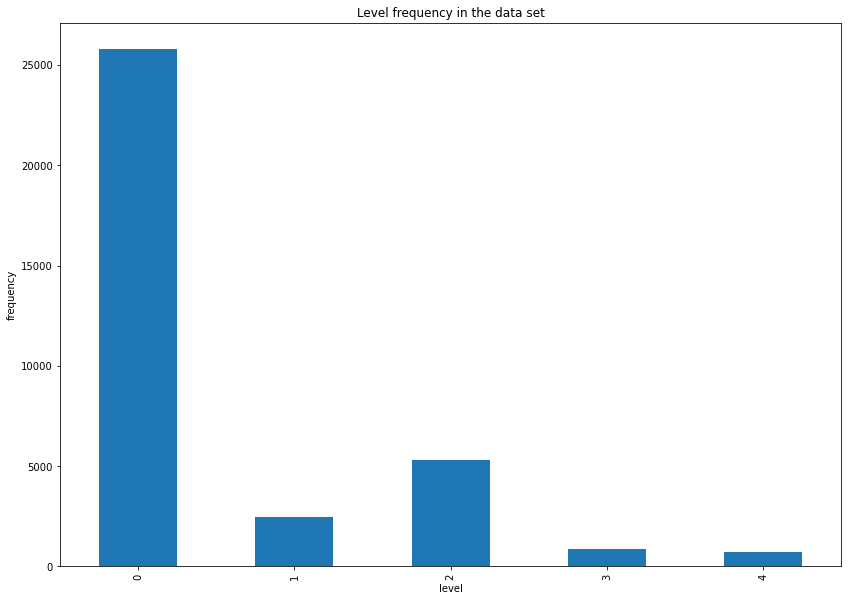

level
0    73.478335
1     6.954962
2    15.065763
3     2.485338
4     2.015601
Name: level, dtype: float64


In [4]:
# plotting the frequency of my classes
plt.figure(figsize = (14,10))
retina_df.groupby('level')['level'].count().plot(kind = 'bar')

plt.ylabel('frequency')
plt.title('Level frequency in the data set')
plt.show()
print(retina_df.groupby('level')['level'].count()/35126*100)

The bar plot above shows us:
-n73.4% of our data is at level 0 meaning no diabetic retinopathy 
-n6.95% is at level 1
- 15% is at level 2
- 2.5% is at level 3
- 2% is at level 4
- this is a huge imbalance that will affect the performance of the models.

## Pre-processing

### resizing images
- as the data set Images are very large (high definition) and vary in size.
-  to unify the size of all images and less runtime I chose to resize them to 400 by 400 pixels.
  

In [ ]:
#resizing all images to 400 height and 400 width
for img in retina_df['path']:  
img_rz = asarray(Image.open(img).resize((400,400)))
Image.fromarray(img_rz).save(img)
   


#### This is how the Images look like Before any preprocessing 


Text(0.5, 1.0, 'Proliferative diabetic retinopathy ')

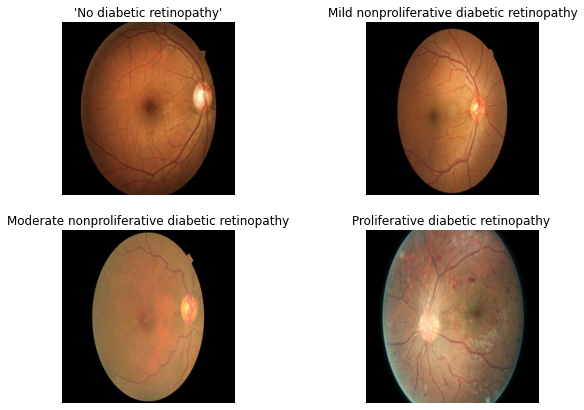

In [72]:
diabetes_levels = ['No diabetic retinopathy',
                'Mild nonproliferative diabetic retinopathy',
               'Moderate nonproliferative diabetic retinopathy',
                'Sever nonproliferative diabetic retinopathy',
                'Proliferative diabetic retinopathy '
                ]

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 2
  
# reading images
Image1 = Image.open('original data/train/13_right.jpeg')
Image2 = Image.open('original data/train/17_right.jpeg')
Image3 = Image.open('original data/train/15_right.jpeg')
Image4 = Image.open('original data/train/16_right.jpeg')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("'No diabetic retinopathy'")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title('Mild nonproliferative diabetic retinopathy')
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title('Moderate nonproliferative diabetic retinopathy')
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title('Proliferative diabetic retinopathy ')

Before I would do any Image processing, I had to first understand the difference between a healthy Eye and a diabetic Eye.
\
After doing some research I found that:
- Over time, too much sugar in the blood can lead to the blockage of the tiny blood vessels that nourish the retina, cutting off its blood supply. As a result, the eye attempts to grow new blood vessels. But these new blood vessels don't develop properly and can leak easily.
\
Now that I know what to look for and where (Blood vessels). I Can Process the Images to make the blood vessels more visible.
The Images Below show 3 different preprocessing methods I took.
- left Image is a normal Gray scale. 
- right Image is global histogram equalization.
- left Image is a local histogram equalization.
I ran a RESNET50 pre-trained transfer Learning model on all 3 different Images and found that the model was able to learn the most from the Global histogram equalization between all 3 methods.
/


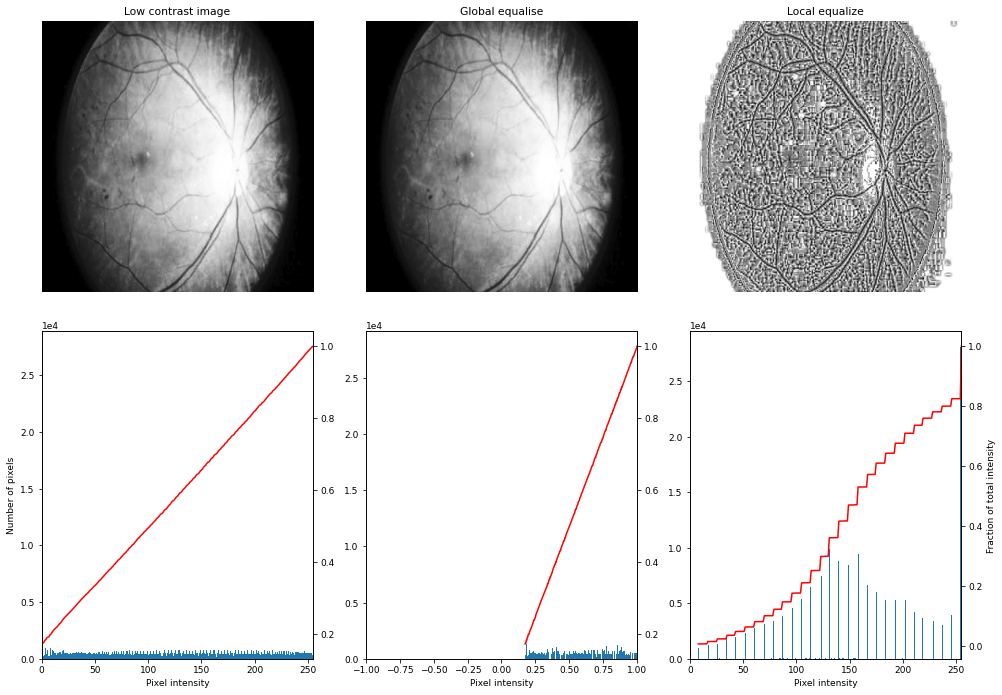

In [84]:
from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.morphology import ball
import skimage.morphology as morp
from skimage.filters import rank
import matplotlib


matplotlib.rcParams['font.size'] = 9


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')

    xmin, xmax = dtype_range[image.dtype.type]
    ax_hist.set_xlim(xmin, xmax)

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')

    return ax_img, ax_hist, ax_cdf


# Load an example image
image_13_right= Image.open('train/41_left.jpeg')
img = img_as_ubyte(image_13_right)

# Global equalize
img_rescale = exposure.equalize_hist(img)

# Equalization
footprint = disk(3)
img_eq = rank.equalize(img, selem=footprint)


# Display results
fig = plt.figure(figsize=(14, 10))
axes = np.zeros((2, 3), dtype=object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')
ax_hist.set_ylabel('Number of pixels')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Global equalise')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Local equalize')
ax_cdf.set_ylabel('Fraction of total intensity')


# prevent overlap of y-axis labels
fig.tight_layout()


Notice how after applying any of the histogram equalization methods the Blood vessels tend to be more visible.
this will allow my model to Detect any leakage or damage helping it in predicting the level of retinopathy.

Applying "Local histogram equalization" to the images using cv2.equalizeHist() which increase the contrast of the image.
- Create a function that will apply an global histogram equalization to the image.
- Looping through the images and applying the equalization function.
 

In [114]:
# Histogram equalization function

def hist_equal(image):
    ''' this function will extract the green channel and preprocess the image to improve it's contrast by using a methode called histogram equalization
    '''
    # Read image file
    img = cv2.imread(image, 2)
    
    # Apply histogram equalization
    equ = cv2.equalizeHist(img)
    # Save file to new directory
    cv2.imwrite( image, equ)



In [ ]:
# looping through all images and applying the histogram equalization function
for img in retina_df['path']:
    hist_equal(img)

The images below are the results of the global histogram equalization applied to the images in the original data set.

Text(0.5, 1.0, 'Proliferative diabetic retinopathy ')

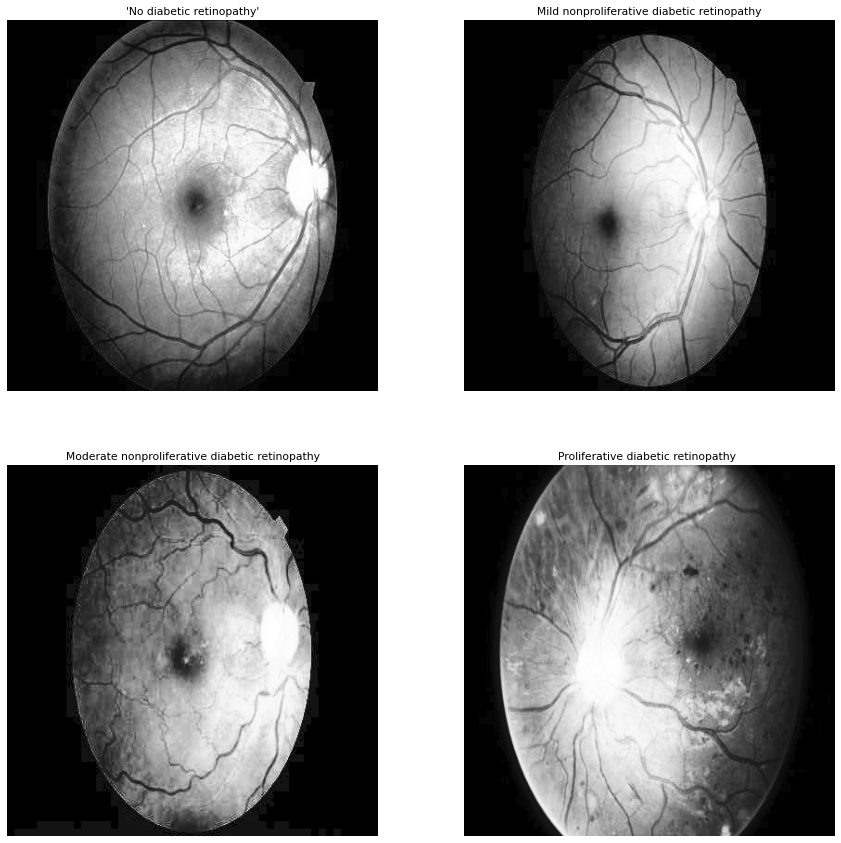

In [95]:
diabetes_levels = ['No diabetic retinopathy',
                'Mild nonproliferative diabetic retinopathy',
               'Moderate nonproliferative diabetic retinopathy',
                'Sever nonproliferative diabetic retinopathy',
                'Proliferative diabetic retinopathy '
                ]

# create figure
fig = plt.figure(figsize=(15, 15))
  
# setting values to rows and column variables
rows = 2
columns = 2
  
# reading images
Image1 = cv2.imread('train/13_right.jpeg')
Image2 = cv2.imread('train/17_right.jpeg')
Image3 = cv2.imread('train/15_right.jpeg')
Image4 = cv2.imread('train/16_right.jpeg')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("'No diabetic retinopathy'")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title('Mild nonproliferative diabetic retinopathy')
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title('Moderate nonproliferative diabetic retinopathy')
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title('Proliferative diabetic retinopathy ')

Notice how some of the Images are are noisy and over exposed Specially in Optical Disc.
\
After doing some research I found a paper discussing different Preprocessing steps to retina Images that will help in improving the detection of DR.
\
The main Steps are:
- Denoising
- Adaptive contrast equalization focused on the Green channel
- Color Normalization (Normalize the color of the image to improve the contrast)

In [ ]:
# applying the above steps on an Image
#opening the image
rgb_img = cv2.imread("train 2/16_right.jpeg")
# applying denoising
img_d = cv2.fastNlMeansDenoisingColored(rgb_img, None, 2, 2, 2, 2)
# splitting thr RGB channels
r_image, g_image, b_image = cv2.split(img_d)

# applying clahe on green channel
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=None)
g_image_eq = clahe.apply(g_image)
# applying clahe on red channel
clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=None)
r_image_eq = clahe.apply(r_image)
# applying clahe on blue channel
clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=None)
b_image_eq = clahe.apply(b_image)
# merging all the channels
image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
# normalizing the image pixels
norm_img = np.zeros((400,400))
final_img = cv2.normalize(image_eq,  norm_img, 0, 255, cv2.NORM_MINMAX)
# saving the preprocessed image
cv2.imwrite('ADE_img/' + img,final_img)

I will save the new preprocessed data in a new folder, as I will have to use the grey scale global Histogram equalization on the machine learning models(logistic, SVM) so I won't run out of memory.
Then I will switch the files directory and run CNN on the New preprocessed Data With adaptive histogram equalization.


Text(0.5, 1.0, 'Global histogram equalization')

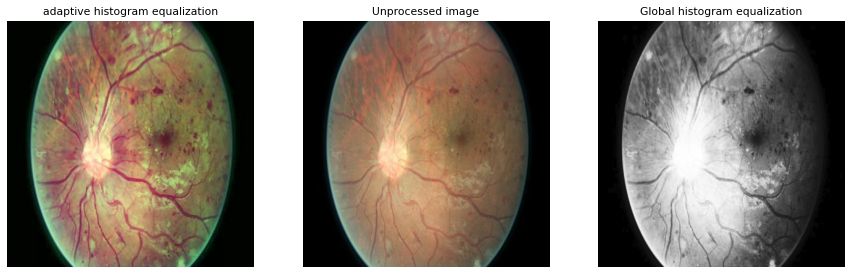

In [94]:
# Plotting
adpt_hist_img= Image.open("train 2/16_right.jpeg")
normal_Image = Image.open("original data/train/16_right.jpeg")
globbal_hist_Image = cv2.imread("train/16_right.jpeg")


fig = plt.figure(figsize=(15,15))
rows = 1
columns = 3
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(adpt_hist_img)
plt.axis('off')
plt.title("adaptive histogram equalization")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(normal_Image)
plt.axis('off')
plt.title('Unprocessed image')

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(globbal_hist_Image)
plt.axis('off')
plt.title('Global histogram equalization')

Notice how the Adaptive equalization managed to reduce the exposure of the optical disk while maintaining high contrast and visibility of the blood vessels, in comparison to the global histogram equalization and unprocessed image.
\
In the code Below I apply the Adaptive equalization to all Images.

In [ ]:
# looping through my images and applying histogram equalization
for img in retina_df['path']:
    #opening the image
    rgb_img = cv2.imread("train 2/16_right.jpeg")
    # applying denoising
    img_d = cv2.fastNlMeansDenoisingColored(rgb_img, None, 2, 2, 2, 2)
    # splitting thr RGB channels
    r_image, g_image, b_image = cv2.split(img_d)

    # applying clahe on green channel
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=None)
    g_image_eq = clahe.apply(g_image)
    # applying clahe on red channel
    clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=None)
    r_image_eq = clahe.apply(r_image)
    # applying clahe on blue channel
    clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=None)
    b_image_eq = clahe.apply(b_image)
    # merging all the channels
    image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
    # normalizing the image pixels
    norm_img = np.zeros((400,400))
    final_img = cv2.normalize(image_eq,  norm_img, 0, 255, cv2.NORM_MINMAX)
    # saving the preprocessed image
    cv2.imwrite(img,final_img)

## Sampling the data
- split the data into remaining and test set 
- splitting the remaining data into training and validation set to perform CNN Model training.
#### Important notes
- while splitting the data I made sure that all class balance are approximately equally represented in the training, validation, remaining and test set. 
- I also made sure that both eyes belonging to a patient are in the same set. It wouldn't be fair if a patient had one eye in training and one eye in test specially that If you'd have DR in one Eye then there is a very high chance of having DR in the other eye.

Splitting the data frame into train and test data

In [ ]:
# splitting the data while making sure patients have both eyes in all sets
rem, test = next(GroupShuffleSplit(test_size=.15, n_splits=2, random_state = 7).split(retina_df, groups=retina_df['Patient_id']))

rem_df = retina_df.iloc[rem]
test_df = retina_df.iloc[test]

In [120]:
# splitting the remaining sample into train and validation
train, validation = next(GroupShuffleSplit(test_size=.15, n_splits=2, random_state = 7).split(rem_df, groups=rem_df['Patient_id']))

train_df = rem_df.iloc[train]
validation_df = rem_df.iloc[validation]

In [123]:
# checking the shape of my Data
print(train_df.shape)
print(test_df.shape)
print(validation_df.shape)

(23884, 5)
(7026, 5)
(4216, 5)


checking if the Target column is distributed similarly between the training, testing and validation sets

In [124]:
# checking for the class percentage by grouping by the class
print((test_df.groupby('level')['level'].count()/7026*100).reset_index(drop = True))
print((validation_df.groupby('level')['level'].count()/4216*100).reset_index(drop = True))
print((train_df.groupby('level')['level'].count()/23884*100).reset_index(drop = True))

0    72.502135
1     7.216055
2    15.684600
3     2.633077
4     1.964133
Name: level, dtype: float64
0    73.173624
1     6.997154
2    15.180266
3     2.395636
4     2.253321
Name: level, dtype: float64
0    73.350360
1     6.975381
2    15.198459
3     2.541450
4     1.934349
Name: level, dtype: float64


notice that the classes share somewhat the same distribution between all sets.

#### taking a small sample of the Data to run the logistic and SVM models on. 
- running all the data require a lot of time and memory(150GB)
- Taking the Global histogram preprocessed images as their shape is 400*400 this way My features will be 2 times smaller than the colored ones.
- Second I tried different sample sizes until I landed on a 10% sample size that my Local Machine Ram can Handle.
  

First I take a 10% sample of the main Dataframe

In [125]:
# taking a sample of the main data frame while stratifying the target column
from sklearn.model_selection import train_test_split
retina_df_sample, sample_to_drop = train_test_split(retina_df, train_size=0.10, stratify=retina_df['level'], random_state=42)

Second I apply the same procedure to the sample data frame to get a training and testing sets

In [127]:
# then splitting the small sample into rem and test sets
from sklearn.model_selection import train_test_split
rem, test = train_test_split(retina_df_sample, test_size=0.15, stratify=retina_df_sample['level'], random_state=42)

In [128]:
# check
print(rem.shape,test.shape)

(2985, 5) (527, 5)


- remaining set has a shape of 2985 rows and 5 columns
- test set has a shape of 527 rows and 5 columns

setting the y_test and y_train to the target column

In [142]:
y_test = test['level']
y_rem = rem['level']

### Turning my train and test data into numpy arrays

- creating a numpay array made of zeros with same required shape 
- converting images into numpay array with 400*400 
- flattening the numpay array and replacing the zeros
- performing this procedure twice once for the X_rem and one for the X_test

In [130]:
# turning the images into flat numpy array
X_rem_sample = np.zeros((2985,400*400), dtype=np.uint8)
for i,img in enumerate(rem['path']):
    
    image= Image.open(img)
    np_img = numpy.array(image)
    
    X_rem_sample[i] = np_img.ravel()
    print(f'{i},{img} appeneded')


0,train\16283_right.jpeg appeneded
1,train\24847_right.jpeg appeneded
2,train\42026_right.jpeg appeneded
3,train\17068_left.jpeg appeneded
4,train\4739_right.jpeg appeneded
5,train\7679_left.jpeg appeneded
6,train\19821_right.jpeg appeneded
7,train\15335_left.jpeg appeneded
8,train\13952_right.jpeg appeneded
9,train\34372_left.jpeg appeneded
10,train\22590_right.jpeg appeneded
11,train\19888_right.jpeg appeneded
12,train\34613_left.jpeg appeneded
13,train\18502_right.jpeg appeneded
14,train\27251_left.jpeg appeneded
15,train\41591_right.jpeg appeneded
16,train\36898_left.jpeg appeneded
17,train\12278_left.jpeg appeneded
18,train\35324_right.jpeg appeneded
19,train\21026_right.jpeg appeneded
20,train\22878_right.jpeg appeneded
21,train\14999_right.jpeg appeneded
22,train\39972_left.jpeg appeneded
23,train\22769_left.jpeg appeneded
24,train\26857_left.jpeg appeneded
25,train\10762_left.jpeg appeneded
26,train\16630_right.jpeg appeneded
27,train\21124_right.jpeg appeneded
28,train\27841_r

In [131]:
# turning the images into flat numpy array
X_test_sample = np.zeros((527,400*400), dtype=np.uint8)
for i,img in enumerate(test['path']):
    
    image= Image.open(img)
    np_img = numpy.array(image)
    
    X_test_sample[i] = np_img.ravel()
    print(f'{i},{img} appeneded')


0,train\62_left.jpeg appeneded
1,train\28077_right.jpeg appeneded
2,train\27617_left.jpeg appeneded
3,train\9653_left.jpeg appeneded
4,train\37639_left.jpeg appeneded
5,train\43779_left.jpeg appeneded
6,train\21281_right.jpeg appeneded
7,train\5995_right.jpeg appeneded
8,train\40089_right.jpeg appeneded
9,train\15244_right.jpeg appeneded
10,train\19935_right.jpeg appeneded
11,train\31027_right.jpeg appeneded
12,train\47_left.jpeg appeneded
13,train\39369_left.jpeg appeneded
14,train\5459_left.jpeg appeneded
15,train\3585_left.jpeg appeneded
16,train\39369_right.jpeg appeneded
17,train\42042_left.jpeg appeneded
18,train\6263_right.jpeg appeneded
19,train\23981_left.jpeg appeneded
20,train\20360_left.jpeg appeneded
21,train\43927_right.jpeg appeneded
22,train\32493_left.jpeg appeneded
23,train\40232_left.jpeg appeneded
24,train\26114_left.jpeg appeneded
25,train\42717_right.jpeg appeneded
26,train\34203_right.jpeg appeneded
27,train\12089_left.jpeg appeneded
28,train\876_right.jpeg appen

In [133]:
#Check
X_test_sample.shape

(527, 160000)

### scalling my data using a Min max scaler to normalize the pixels
- I also changed the type of the data to float32 to reduce memory usage.

In [149]:
# scalling the numpay array 
scaler = MinMaxScaler()
# fitting on the remaining data
scaler.fit(X_rem_sample)
# transforming both data sets
X_rem_scaled = scaler.transform(X_rem_sample)
X_test_scaled = scaler.transform(X_test_sample)
# changing the type to float32 to reduce memory usage
X_test_scaled = X_test_scaled.astype(np.float32)
X_rem_scaled = X_rem_scaled.astype(np.float32)

Saving my scaled features as a pickeled file

In [150]:
# Pickeling my scaled test data
filename = 'scaled_test_sample'
outfile = open(filename,'wb')
pickle.dump(X_test_scaled,outfile)
outfile.close()

In [151]:
# Pickeling my scaled train data
filename = 'scaled_rem_sample'
outfile = open(filename,'wb')
pickle.dump(X_rem_scaled,outfile)
outfile.close()

In [6]:
# to load the pickeled data 
infile_rem = open('scaled_rem_sample','rb')
X_rem_scaled = pickle.load(infile_rem)
infile_rem.close()

infile_test = open('scaled_test_sample','rb')
X_test_scaled = pickle.load(infile_test)
infile_test.close()

### Feature engendering with PCA
- using feature engendering to reduce the number of my dimensions while maintaining 0.999% of the data
- this will get rid of all the black frame around the retina images as PCA will remove features with very low variance. 
- My model was not able to run without PCA as it have 160000 features.

In [153]:

# applying PCA to the sampled Data
pca = PCA(n_components=.999)
pca.fit(X_rem_scaled)

# transform data 
X_rem_PCA = pca.transform(X_rem_scaled)
X_test_PCA = pca.transform(X_test_scaled)


In [154]:
X_test_PCA.shape

(527, 2634)

Saving my New features as a pickeled file

In [155]:


filename = 'PCA_test_sample'
outfile = open(filename,'wb')
pickle.dump(X_rem_PCA,outfile)
outfile.close()

In [156]:


filename = 'PCA_rem_sample'
outfile = open(filename,'wb')
pickle.dump(X_test_PCA,outfile)
outfile.close()

In [134]:
# to load the pickeled  PCA files
infile_rem = open('PCA_rem_sample','rb')
X_rem_PCA = pickle.load(infile_rem)
infile_rem.close()

infile_test = open( 'PCA_test_sample','rb')
X_test_PCA = pickle.load(infile_test)
infile_test.close()

In [158]:
print(X_test_PCA.shape)
print(X_rem_PCA.shape)

(527, 2634)
(2985, 2634)


PCA has done an Amazing Job by reducing the number of features from 160000 to 2634 while maintaining 99.9% of the variance
It's true that this will cause my models to be much harder to interpret as the cofessient right now do not represent the pixels, but without this step My models would not have been able to Run with that many features

### fitting my Multi class data to  Logistic regression Model
- optimizing for value of C.
- Using a liblinear Solver 
- max_iter of 2000
- using cross validation to find the best value of C.
- Adding a Class weights Balanced argument as my data is very imbalanced.

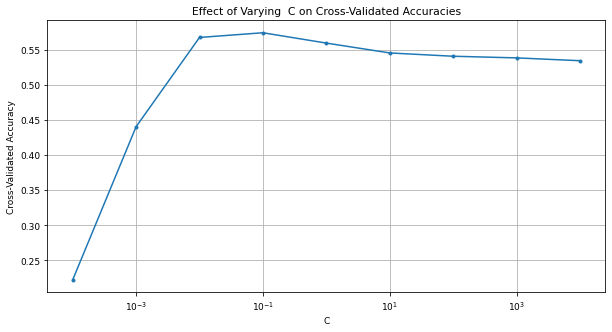

The best model has a depth =  0.1


In [167]:
# creating an empty list to append the validation scores to it
vc_acc_scores = []


# setting the values of C that I want to test
C_values = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000,10000]


for c in C_values:

    retina_logmodel_cv = LogisticRegression(solver='liblinear', C = c,max_iter=2000,class_weight='balanced' ).fit(X_rem_PCA, y_rem)

    
    #cross validation
    cv_accuracy = np.mean(cross_val_score(retina_logmodel_cv, X_rem_PCA, y_rem, cv=5, n_jobs=-1))
    vc_acc_scores.append(cv_accuracy)

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(C_values, vc_acc_scores, marker = '.')
plt.title('Effect of Varying  C on Cross-Validated Accuracies')
plt.xscale('log') 
plt.xlabel('C')
plt.ylabel('Cross-Validated Accuracy')
plt.grid()
plt.show()
which_vc = np.array(vc_acc_scores).argmax()

print("The best model has a depth = ",C_values[which_vc] )


Cross validation score peaked at almost 58% accuracy with a C value of 0.01. let's see how the model will perform on the test data

In [168]:
# fitting a logestic regression with C value of 0.01

retina_logmodel_cv = LogisticRegression(solver='liblinear', C = C_values[which_vc],max_iter=2000,class_weight='balanced' ).fit(X_rem_PCA, y_rem)
print(retina_logmodel_cv.score(X_test_PCA, y_test))
    # get predicted y values for the test set

test_score = retina_logmodel_cv.score(X_test_PCA, y_test)
y_pred = retina_logmodel_cv.predict(X_test_PCA)

# generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# get target names
cols = y_test.unique()

# convert to a DataFrame
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted No DR", "Predicted Mild DR"
           ,"Predicted Moderate DR"
           ,"Predicted Sever DR"
           ,"Predicted Proliferative DR"],
    index=["True No DR", "True Mild DR"
           ,"True Moderate DR"
           ,"True Sever DR"
           ,"True Proliferative DR"])


print(f'test accuracy is: {test_score}')
display(cf_df)

# Classification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)



0.6565464895635673
test accuracy is: 0.6565464895635673


,Predicted No DR,Predicted Mild DR,Predicted Moderate DR,Predicted Sever DR,Predicted Proliferative DR
True No DR,336,13,34,2,2
True Mild DR,31,0,6,0,0
True Moderate DR,64,1,10,1,3
True Sever DR,11,1,1,0,0
True Proliferative DR,6,0,5,0,0


              precision    recall  f1-score   support

           0       0.75      0.87      0.80       387
           1       0.00      0.00      0.00        37
           2       0.18      0.13      0.15        79
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        11

    accuracy                           0.66       527
   macro avg       0.19      0.20      0.19       527
weighted avg       0.58      0.66      0.61       527



The models test accuracy is 65.6%. even though the accuracy seems to be good, if we look at the heat map below we notice that the model was only able to predict the no DR class as it it represent 74% of the data even though I added the Class weight argument to the model. But it failed to correctly predict any other Level of diabeties except for level 2(moderate DR) it was able to predict 15% of the Moderate DR correctly.
- The Precision and recall for the No DR are quit high 75% precision and 87 recall.
- on the other hand the precision  and recall for all the other classes are really low.
- Same for the F1 score very high for No DR and very Low for the other classes.


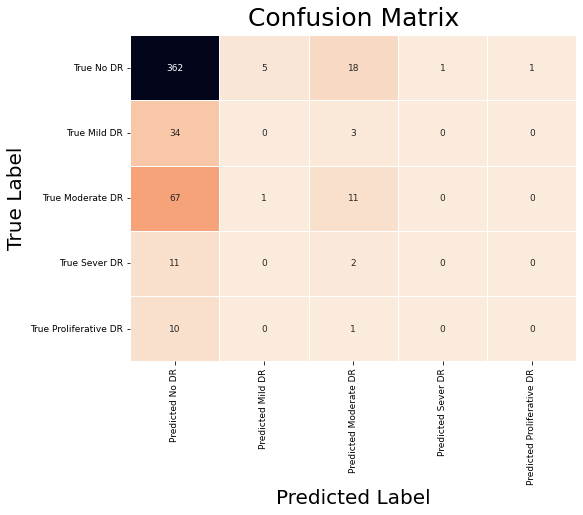

In [177]:
# plotting the confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(cf_df ,
            annot=True,
            fmt='g',
            cbar=False,
            cmap="rocket_r",
            linewidths=1,           
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

### Fitting imbalanced Data on Support Vector Machine
- performing cross validation to find the optimal Value of c_candidates
- adding a class_weight argument as Balanced this will allow my model to learn more from the minority classes.
- using the kernel rbf which is a non linear SVM and it can perform better classification. 

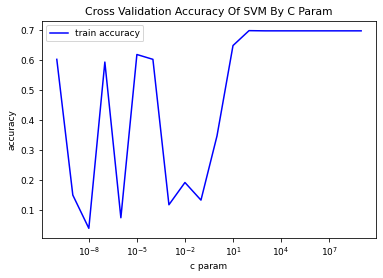

In [170]:
#
c_candidates = 10**np.arange(-10.0,10.0)

vc_acc = []


# need to loop through the hyperperameter C values to optimize the model

for c in c_candidates:
    
    SVM = SVC(C = c, kernel = 'rbf', class_weight='balanced')
    SVM.fit( X_rem_PCA,y_rem)
# Cross validation   
    cv_accuracy = np.mean(cross_val_score(SVM, X_rem_PCA, y_rem, cv=5, n_jobs=-1))
    vc_acc.append(cv_accuracy)
# plotting cross val acuracy
plt.figure()
plt.plot(c_candidates,vc_acc,c = 'blue',label = 'CV accuracy')
plt.xscale('log')
plt.legend()
plt.xlabel('c param')
plt.ylabel('accuracy')
plt.title('Cross Validation Accuracy Of SVM By C Param')
plt.show()

My cross validation accuracy fluctuated when the C value was less than 0  but increased to be around 70% when the C value was above 0. 
- I will use the C value of 100 to run the model on my test set Below

In [173]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

SVM =SVC(C = 100, kernel = 'rbf', class_weight='balanced')
SVM.fit( X_rem_PCA,y_rem)
print(SVM.score(X_test_PCA, y_test))
    # get predicted y values for the test set

test_score = SVM.score(X_test_PCA, y_test)
y_pred = SVM.predict(X_test_PCA)

# generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)



# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted No DR", "Predicted Mild DR"
           ,"Predicted Moderate DR"
           ,"Predicted Sever DR"
           ,"Predicted Proliferative DR"],
    index=["True No DR", "True Mild DR"
           ,"True Moderate DR"
           ,"True Sever DR"
           ,"True Proliferative DR"])
display(cf_df)

print(f'test accuracy is: {test_score}')


# Classification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)


0.7077798861480076


,Predicted No DR,Predicted Mild DR,Predicted Moderate DR,Predicted Sever DR,Predicted Proliferative DR
True No DR,362,5,18,1,1
True Mild DR,34,0,3,0,0
True Moderate DR,67,1,11,0,0
True Sever DR,11,0,2,0,0
True Proliferative DR,10,0,1,0,0


test accuracy is: 0.7077798861480076
              precision    recall  f1-score   support

           0       0.75      0.94      0.83       387
           1       0.00      0.00      0.00        37
           2       0.31      0.14      0.19        79
           3       0.00      0.00      0.00        13
           4       0.00      0.00      0.00        11

    accuracy                           0.71       527
   macro avg       0.21      0.21      0.20       527
weighted avg       0.60      0.71      0.64       527



The SVM models test accuracy is 70%. even though the accuracy seems to be good,  if we look at the heat map below we notice that the model was only able to predict the no DR class as it it represent 74% of the data.
the model performance is slightly better than the Logistic regression model before.
even though I added the Class weight argument to the model, it also failed to correctly predict any other Level of diabeties, except for level 2(moderate DR) it was able to predict 14% of the Moderate DR correctly.
- The Precision and recall for the No DR are quit high 75% precision and 94% recall.
- on the other hand the precision  and recall for all the other classes are really low.
- Same for the F1 score very high for No DR and very Low for the other classes.


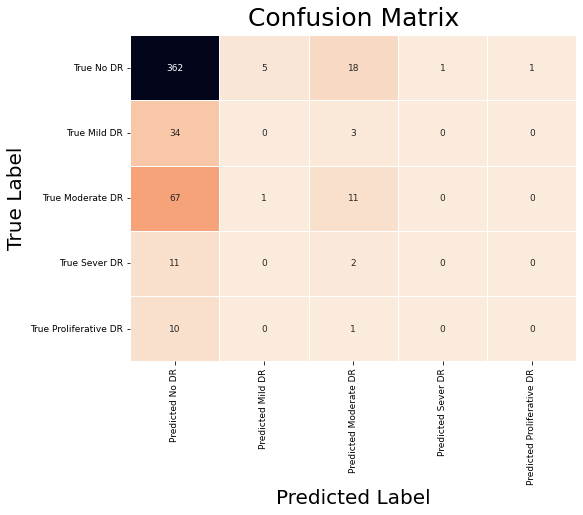

In [176]:


plt.figure(figsize = (8,6))
sns.heatmap(cf_df ,
            annot=True,
            fmt='g',
            cbar=False,
            cmap="rocket_r",
            linewidths=1,
           )
plt.title('Confusion Matrix')
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)



plt.show()

## CNN

For CNN I will be Using the split data set.
- I will be using ImageDataGenerator to generate batches of images sd I won't be able to feed the model all my data at once.
- Image Data Generator requires the Target to be a string so in the Code below I change the type of my target to be a string.
- I will be using the adaptive histogram equalized images For the CNN model with all 3 RGB channels.

In [9]:
# Changing the type of the target for training, validation and test sets
train_df['level'] = train_df['level'].astype(str)
validation_df['level']= validation_df['level'].astype(str)
test_df['level']= test_df['level'].astype(str)

C:\Users\zedal\AppData\Local\Temp/ipykernel_32020/3608092317.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['level'] = train_df['level'].astype(str)
C:\Users\zedal\AppData\Local\Temp/ipykernel_32020/3608092317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['level']= validation_df['level'].astype(str)
C:\Users\zedal\AppData\Local\Temp/ipykernel_32020/3608092317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Before Feeding Images into the model I will First need to perform:
- Image augmentation on the training Images  (rotation, scaling, flipping,shear,Brightness adjustment,horizontal flip, rescaling and zooming) all the augmentations will be subtle but will allow my model to learn more and be able to predict the classes in the test set.
- I will rescale the validation data set as well
- My images will have a shape of 400*400 pixels and 3 channels.
- I will use the method flow from dataframe and specify the Path for the images and the target.
- this will allow my data generator to extract images from the directory and feed them to the model.
- I tried different Batch sizes and 75 was the biggest batch that My local gpu can handel.

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# specify the hight and width and number of channels
height = 400 
width = 400
channels = 3 
# perform random data augmentation on the train data while rescaling the data
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 30,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.2,1.0],
                                   horizontal_flip=True,
                                   
                                   )
# rescale the validation data
Validation_datagen = ImageDataGenerator(rescale=1./255)
                                   
                                   
                                   
#  Extracting the train images from the dataframe                                  
Train_df_gen = train_datagen.flow_from_dataframe(
    train_df, y_col='level',x_col = 'path',
     color_mode='rgb',path_col = train_df['path'],
     class_mode='categorical', shuffle=True, target_size=(height,width),
                                                 
                                                 batch_size=75
                                                 
    
    
)
#  Extracting the Validation images from the dataframe  

Val_df_gen = Validation_datagen.flow_from_dataframe(
    validation_df, y_col='level',x_col = 'path',
     color_mode='rgb',path_col = validation_df['path'],
     class_mode='categorical', batch_size=75, shuffle=True,target_size=(height,width)
                                                 
                                                 )

Found 23884 validated image filenames belonging to 5 classes.
Found 4216 validated image filenames belonging to 5 classes.


below is a sample of the validation Images.

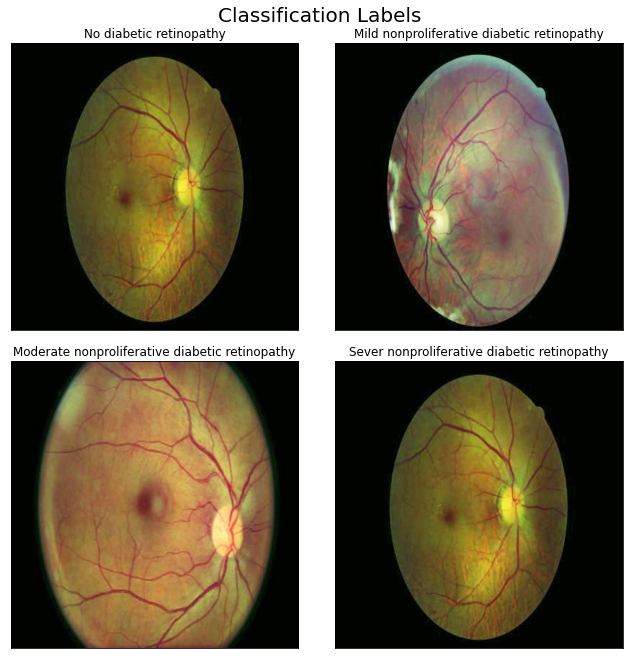

In [11]:
# Grab a batch of images from our validation generator: 
x, y = Val_df_gen.next() 

# Our images labels are one-hot encoded, lets 
# convert them to ordinal encoding
labels = np.argmax(y, axis=1)


diabetes_levels = ['No diabetic retinopathy',
                'Mild nonproliferative diabetic retinopathy',
               'Moderate nonproliferative diabetic retinopathy',
                'Sever nonproliferative diabetic retinopathy',
                'Proliferative diabetic retinopathy '
                ]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(9, 14))
ax = ax.flatten()

for i in range(0,5):
    
    index = np.argmax(labels==i) 
    ax[i].imshow(x[index])
    
    # Set the title of the subplot
    ax[i].set_title(diabetes_levels[i])
    
    # Hide the x and y ticks
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])
    

fig.suptitle("Classification Labels", size = 20)
fig.tight_layout()

# Delete the two unused subplots
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])

#### Building the model layers
Now that the data is scaled and reshaped to the proper form, I can build our model.
- I will start with <code> keras.models.Sequential </code>. This allows us to simply construct each layer one at a time by adding them to this Sequential model.
- then I will use <code> keras.layers.Conv2D </code> this Convolution Layer will extract features from the image.
- followed by <code> keras.layers.MaxPooling2D </code> this sequence of convolution and pooling is repeated until the dimensionality has been lowered.
- I increased the pooling layer to (3,3) to reduce the number of parameters. 
- adding <code> keras.layers.Dropout </code> to reduce overfitting as much as possible. 
-  I will use <code> keras.layers.Flatten </code> to convert the output of the convolutional layers to a 1D vector.
- For the finall layers I will add <code> keras.layers.Dense </code>  this will  use the features that were learned from the convolutional layers to make the final prediction. As usual, the final prediction layer has its output size set to the number of classes. 


In [12]:
CNN_model = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (400, 400, 3)))
CNN_model.add(MaxPooling2D(pool_size=(3, 3)))
CNN_model.add(Dropout(0.25))
CNN_model.add(MaxPooling2D(pool_size=(3, 3)))
CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(3, 3)))
CNN_model.add(Dropout(0.25))

# Flatten the output of our convolutional layers
CNN_model.add(Flatten())

# Add dense layers

CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dense(64, activation='relu'))

CNN_model.add(Dense(5, activation='softmax'))

# Print out a summary of the network
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 132, 132, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 132, 132, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 44, 44, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

Notice the 1,633,733 Trainable parameters

- In the code Cell below I compile my model with the Adam optimizer and the categorical crossentropy loss function.
- I add an early stop so where it monitor the validation Loss so my model won't run without any improvement. it will stop the model from running if validation loss doesn't improve for 2 epochs.
-  I then fit my model with trained and validation data and set the number of epochs to 10.
- then I save the weights of my model

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           
                           verbose=1)
CNN_model.fit(Train_df_gen,
            epochs=10,
            validation_data = Val_df_gen,
            callbacks=[early_stop])
model_name = 'my_model_resnet_unbalanced.h5'
CNN_model.save(model_name)

Epoch 1/10
319/319 [==============================] - 2333s 7s/step - loss: 0.8821 - accuracy: 0.7321 - val_loss: 0.8722 - val_accuracy: 0.7317
Epoch 2/10
319/319 [==============================] - 1894s 6s/step - loss: 0.8699 - accuracy: 0.7335 - val_loss: 0.8855 - val_accuracy: 0.7317
Epoch 3/10
319/319 [==============================] - 1241s 4s/step - loss: 0.8672 - accuracy: 0.7335 - val_loss: 0.8747 - val_accuracy: 0.7317
Epoch 00003: early stopping


The early stopping function stops my model after the 3rd epoch as neither validation or accuracy has improved for all 3 epochs.
- validation score was constant 73%
- training accuracy was also stable 73.3%
- the validation loss worsened with every epoch.
- while the training loss improved slightly. 
Let's test the model on the test data.

Using the same Image data generator method I used for the validation data, on the test data with a batch size of 200

In [181]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, y_col='level',x_col = 'path',
     color_mode='rgb',path_col = test_df['path'],
     class_mode='categorical', batch_size=200, shuffle=True,target_size=(height,width))
                                                 

X_test, y_test = test_generator.next()

Found 7026 validated image filenames belonging to 5 classes.


In [188]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
score = CNN_model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Calculate the predictions
predict_probas = CNN_model.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

# Generate confusion matrix
cf_matrix = confusion_matrix(labels, y_predict)
# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted No DR", "Predicted Mild DR"
           ,"Predicted Moderate DR"
           ,"Predicted Sever DR"
           ,"Predicted Proliferative DR"],
    index=["True No DR", "True Mild DR"
           ,"True Moderate DR"
           ,"True Sever DR"
           ,"True Proliferative DR"])
display(cf_df)


7/7 [==============================] - 1s 39ms/step - loss: 1.0280 - accuracy: 0.7000
Test loss: 1.0280327796936035
Test accuracy: 0.699999988079071


,Predicted No DR,Predicted Mild DR,Predicted Moderate DR,Predicted Sever DR,Predicted Proliferative DR
True No DR,143,0,0,0,0
True Mild DR,10,0,0,0,0
True Moderate DR,36,0,0,0,0
True Sever DR,4,0,0,0,0
True Proliferative DR,7,0,0,0,0


The CNN model scored a 70% test score but looking at the confusion matrix I can see that the CNN model performed worse than the SVM or Logistic regression models.
- that's very predictable as It was a very shallow neural network and I didn't not specify any class weights to allow the model to learn more from specific classes.

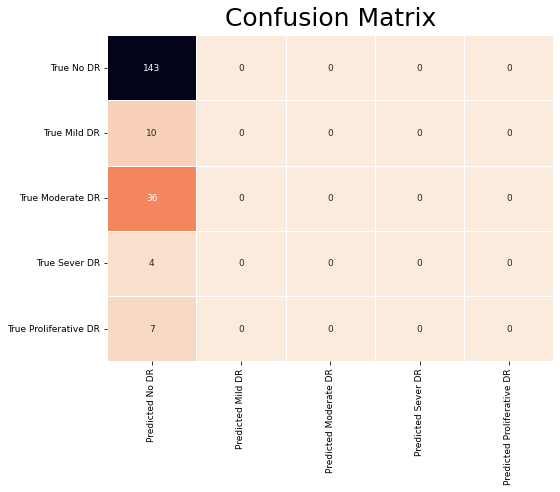

In [186]:
# Plot the confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(cf_df ,
            annot=True,
            fmt='g',
            cbar=False,
            cmap="rocket_r",
            linewidths=1
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)



plt.show()

### Conclusion
It is obious to me that no model will be able to predict any of the classes when The data is highly imbalanced.
- all models were able to predict the no dR class very well but failed to predict any other. 
- My main focus is to improve the Recall for all classes even if the percision is not as high, I prefer to have a higher false positive rate, than false Negative. 
- In medical cases it's better to tell patients that they need to perform more testing as they might be diagnosed with a disease over sending them home as healthy when they actually have an illness.
- Refer to the Notebook "Modeling with Balanced Data" to see how the models performed after upsampling the minority classes.